In [3]:
%load_ext Cython

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
global width, height
width = 1392; height=1024;

pixel_size=6.45e-6
amplication = 2.5
cut_range=200
cutoff_high = 5.
fitting_range = 300

lambda_0 = 589e-9
sigma_0 = 3*lambda_0**2/(4*np.pi) #cross section of atom per nm^2
sodium_mass=22.989770*1.6605391e-27
k_b = 1.38064852e-23

wx=2*np.pi*5.
wy=2*np.pi*8.8
wz=2*np.pi*640.6

In [4]:
class SPEFile(object):
    def __init__(self, fname):
        self._fid = open(fname, 'rb')
        self._load_size()
    def _load_size(self):
        self._xdim = np.int64(self.read_at(42, 1, np.int16)[0])
        self._ydim = np.int64(self.read_at(656, 1, np.int16)[0])
    def read_at(self, pos, size, ntype):
        self._fid.seek(pos)
        return np.fromfile(self._fid, ntype, size)
    def load_img(self, offset = 0):
        img = self.read_at(4100 + 2*offset * self._xdim * self._ydim, self._xdim * self._ydim, np.uint16)
        return img.reshape((self._ydim, self._xdim))
    def close(self):
        self._fid.close()

def load_QGL_SPE(fname):
    fid = SPEFile(fname)
    img0 = fid.load_img(0) # Absorption image when atom exists
    img1 = fid.load_img(1) # Image after blowing the atoms
    img2 = fid.load_img(2) # Dark Background
    fid.close()
    return (img0.astype('double'), img1.astype('double'), img2.astype('double'))

def plotimg (img) : # To plot each Int16 2-dimension array data.
    X, Y = np.meshgrid(np.linspace(0,width-1,width), np.linspace(0,height-1,height))
    plt.pcolor(X,Y,img)
    plt.colorbar()
    plt.show()

def AbsorptionImage (images): # calculate optical depth
    image = np.array(load_QGL_SPE(images))

    img_res = [[0.0 for i in range (width)] for j in range (height)]

    for i in range(height):
        for j in range(width):
            if (image[1][i][j]-image[2][i][j]) < 0.1 or (image[0][i][j]-image[2][i][j]) < 0.1:
                img_res[i][j] = 0.
            else:
                img_res[i][j] = -np.log((image[0][i][j]-image[2][i][j]) / (image[1][i][j]-image[2][i][j]))

    for i in range(width):
        for j in range(height):
            if abs(img_res[j][i]) >= cutoff_high:
                img_res[j][i] = 0.
    res=np.array(img_res)
    return res

In [46]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
cimport numpy as cnp

cdef int width = 1392
cdef int height=1024;

cdef double pixel_size=6.45e-6
cdef double amplication = 2.5
cut_range=200
cutoff_high = 5.
fitting_range = 300

cdef double lambda_0 = 589e-9
cdef double sigma_0 = 3*lambda_0**2/(4*np.pi) #cross section of atom per nm^2
cdef double sodium_mass=22.989770*1.6605391e-27
cdef double k_b = 1.38064852e-23

cdef double wx=2*np.pi*5.
cdef double wy=2*np.pi*8.8
cdef double wz=2*np.pi*8.8*640.6

cpdef atom_number(cnp.ndarray[cnp.double_t,ndim=2] result): # count all atom numbers / you can count atoms in the region which you want by set parameter like result[a:b,c:d] 

    cdef int y_lim = result.shape[0]
    cdef int x_lim = result.shape[1]
    cdef cnp.ndarray res = np.zeros([y_lim,x_lim])
    
    for y in range(y_lim):
        for x in range(x_lim):
            if result[y][x] <= 0.:
                res[y][x] = 0.
            else:
                res[y][x] = 1/sigma_0*result[y][x]*(pixel_size/amplication)**2

    result1=0.
    
    for y in range(y_lim):
        for x in range(x_lim):
            result1 = result1+ res[y][x]

    print(result1)

    return result1


cpdef Plot_atom_density(double[:,:] result,int x0,int y0,int r): #Plot atom density along r direction
    #Plot_atom_density(x position of center (type int ), y position of center (type int), radius (type int)  )

    cdef int y_lim = result.shape[0]
    cdef int x_lim = result.shape[1]
    cdef cnp.ndarray n_r = np.zeros(r)
    cdef double sum1=0.
    cdef int i,j,l

    cdef int count1=1
    for l in range(r):
            count2=0
            sum2=0.
            if l==0: n_r[l]=result[y0][x0]
            else:
                for i in range(width):
                    for j in range(height):
                        if (i-x0)**2+(j-y0)**2 <= l*l:
                            sum2=sum2+result[j][i]
                            count2=count2+1
                n_r[l]=(sum2-sum1)/(count2-count1)
                sum1=sum2
            count1=count2

    plt.plot(range(0,r),n_r)
    plt.show()
    
    return n_r
    

    


cdef inline BEC(double x,double x0,double sigma,double A1):# define BEC distribution by paraboloid
    cdef double result
    result = (1-((x-x0)/sigma)**2)
    return A1*result**1.5 if result>0 else 0


cdef inline Gaussian2D(double x,double x0,double gsigma,double A2,double B): #Define 2D Gaussian function
    return B + A2*np.exp(-((x-x0)/gsigma)**2)


cdef integration_x(double[:,:] result):
    cdef cnp.ndarray[cnp.double_t, ndim=1] res_x= np.zeros(width)
    cdef int i,j

    for j in range(width):
        res_x[j]=0.
        for i in range(height):
            res_x[j]=res_x[j]+result[i][j]
    return res_x


cdef integration_y(result):
    res_y=np.zeros(height)
    for j in range(height):
        res_y[j] = 0.
        for i in range(width):
            res_y[j]=res_y[j]+result[j][i]
    return res_y



cdef ERR(cnp.ndarray[cnp.double_t,ndim=1] x, cnp.ndarray[cnp.double_t,ndim=1] bprms):
    cdef int i

    esum = 0
    for i in range(x.size):
        esum=esum+(x[i] - BEC(i, bprms[0],bprms[1],bprms[3])-Gaussian2D(i,bprms[0],bprms[2],bprms[4],bprms[5]))**2
    
    result=esum

    return result


cpdef Fit_BEC(double[:,:] result, double lr,int num,double tof): # fitting BEC gas by paraboloid +gaussian, and calculate temperature, r^2, and Thomas-Fermi radius 
    cdef cnp.ndarray[cnp.double_t,ndim=1] res_x = integration_x(result)
    cdef cnp.ndarray[cnp.double_t,ndim=1] res_y = integration_y(result)
    cdef double h = 0.01
    cdef int idx,idy
    
    cdef cnp.ndarray bprms1=np.array([800.,150.,150.,200.,50.,0.])
    cdef cnp.ndarray bprms2=np.array([600.,150.,150.,200.,50.,0.])
    cdef cnp.ndarray grad1=np.zeros_like(bprms1)
    cdef cnp.ndarray grad2=np.zeros_like(bprms2)

    for loop in range(num):
        for idx in range(bprms1.size):
            tmp_val1 = bprms1[idx]
            bprms1[idx]=tmp_val1
            err0=ERR(res_x,bprms1)

            bprms1[idx]=tmp_val1+h
            err1=ERR(res_x,bprms1)
            bprms1[idx]=tmp_val1
            grad1[idx]=(err1-err0)/(h)
        for idy in range(bprms2.size):
            tmp_val2 = bprms2[idy]
            err00 = ERR(res_y, bprms2)

            bprms2[idy] = tmp_val2 + h
            err11 = ERR(res_y, bprms2)
            bprms2[idy]=tmp_val2
            grad2[idy] = (err11 - err00) / h
        bprms1=bprms1-lr*grad1
        bprms2=bprms2-lr*grad2
    graph1=[]
    graph2=[]
    for i in range(res_x.size):
        graph1.append(BEC(i, bprms1[0], bprms1[1], bprms1[3]) + Gaussian2D(i, bprms1[0], bprms1[2], bprms1[4], bprms1[5]))
    for j in range(res_y.size):
        graph2.append(BEC(j, bprms2[0], bprms2[1], bprms2[3]) + Gaussian2D(j, bprms2[0], bprms2[2], bprms2[4], bprms2[5]))
    fig = plt.figure()
    hor = fig.add_subplot(2, 1, 1)
    ver = fig.add_subplot(2, 1, 2)

    hor.plot(range(res_x.size),res_x, 'b')
    hor.plot(range(res_x.size),graph1, 'k')
    ver.plot(range(res_y.size), res_y, 'r')
    ver.plot(range(res_y.size), graph2, 'k')
    plt.show()
    
    cdef double x_mean=0.
    for i in range(res_x.size):
        x_mean=x_mean+res_x[i]
    x_mean=x_mean/res_x.size
    
    cdef double y_mean=0.
    for i in range(res_y.size):
        y_mean=y_mean+res_y[i]
    y_mean=y_mean/res_y.size
    
    cdef double x_sst=0.
    for i in range(res_x.size):
        x_sst=x_sst+(res_x[i]-x_mean)**2
    
    cdef double y_sst=0.
    for i in range(res_y.size):
        y_sst=y_sst+(res_y[i]-y_mean)**2
        
    x_ssr=ERR(res_x,bprms1)
    print("x integration fitting r^2=%lf" %(1-(x_ssr/x_sst)))
    
    y_ssr=ERR(res_y,bprms2)
    print("y integration fitting r^2=%lf"%(1-(y_ssr/y_sst)))
    
    temperature = sodium_mass/(2*k_b)*((wx)**2/(1+(wx*tof)**2)*(bprms1[2]*pixel_size/amplication)**2+(wy)**2/(1+(wy*tof)**2)*(bprms2[2]*pixel_size/amplication)**2)
    print("Temperature = %lf µK" %(temperature*1e+6))
    print("R_x=%lf µm"%(bprms1[1]*pixel_size/amplication*1e+6))
    print("R_y=%lf µm"%(bprms2[1]*pixel_size/amplication*1e+6))
    return bprms1,bprms2

"""cpdef get_temperature(double[:,:] result,int num, double lr,double tof):
    cdef cnp.ndarray n_r = Plot_atom_density(result,945,652,200)
    cdef double h = 0.005
    cdef cnp.ndarray prms=np.array([0.,70.,100.,2.5,0.1,0.])
    cdef cnp.ndarray grad=np.zeros(6)
        
    for loop in range(num):
        for idx in range(6):
            if idx<3:
                tmp_val1 = prms[idx]
                prms[idx]=tmp_val1-30*h
                prms[0]=0.
                prms[5]=0.
                err0=ERR(n_r,prms)
                prms[idx]=tmp_val1

                prms[idx]=tmp_val1+30*h
                prms[0]=0.
                prms[5]=0.
                err1=ERR(n_r,prms)
                prms[idx]=tmp_val1
                grad[idx]=(err1-err0)/(60*h)
                prms=prms-80*lr*grad
            else:
                tmp_val1 = prms[idx]
                prms[idx]=tmp_val1-h
                prms[0]=0.
                prms[5]=0.
                err0=ERR(n_r,prms)
                prms[idx]=tmp_val1

                prms[idx]=tmp_val1+h
                prms[0]=0.
                prms[5]=0.
                err1=ERR(n_r,prms)
                prms[idx]=tmp_val1

                grad[idx]=(err1-err0)/(2*h)
                prms=prms-lr*grad
        
    graph=[]
    for i in range(n_r.size):
        graph.append(BEC(i, prms[0], prms[1], prms[3]) + Gaussian2D(i, prms[0], prms[2], prms[4], 0.))
        
    plt.plot(range(n_r.size),n_r, 'b')
    plt.plot(range(n_r.size),graph, 'k')
    plt.show()
    cdef double sigma = prms[2] * pixel_size / amplication
    cdef double numerator=(2 * tof ** 2 * k_b)
    cdef double temp = sodium_mass * sigma ** 2 / numerator
    print("Temperature = %lf micro K" %(temp*1e+6))
    print(prms)"""

    

In [11]:
result=AbsorptionImage('C:/Users/ndg05/Desktop/BECdata/KZ FB5_405 ODT2_4to0_95in2000ms hold0ms0.spe')

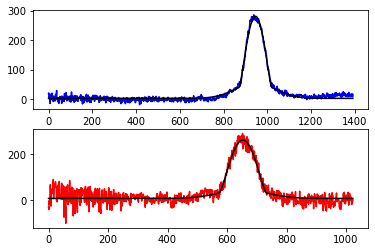

x integration fitting r^2=0.986026
y integration fitting r^2=0.888385
Temperature = 0.339805 µK
R_x=193.307030 µm
R_y=204.526418 µm


(array([945.51132486,  74.92520552, 127.73591786, 226.03262812,
         52.17410931,   3.44228337]),
 array([653.19222768,  79.27380551, 114.50278072, 215.02626666,
         38.0212051 ,   8.55411486]))

In [47]:
Fit_BEC(result,0.0005,200,0.015)

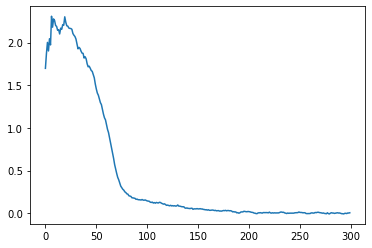

array([ 1.69866905e+00,  1.87080212e+00,  2.00272317e+00,  1.90264381e+00,
        2.04560444e+00,  1.97321953e+00,  2.30913034e+00,  2.18084314e+00,
        2.27769841e+00,  2.25919064e+00,  2.20114278e+00,  2.19000190e+00,
        2.14425275e+00,  2.15147011e+00,  2.10158943e+00,  2.16922563e+00,
        2.15660213e+00,  2.21096718e+00,  2.20356575e+00,  2.30246494e+00,
        2.23897235e+00,  2.19695843e+00,  2.19357380e+00,  2.17098479e+00,
        2.16660048e+00,  2.16521609e+00,  2.15624221e+00,  2.10678274e+00,
        2.08660306e+00,  2.07171748e+00,  2.04235312e+00,  1.98562102e+00,
        1.92757061e+00,  1.94435367e+00,  1.93124481e+00,  1.89987371e+00,
        1.87670434e+00,  1.87409852e+00,  1.81950364e+00,  1.83459806e+00,
        1.81020344e+00,  1.75179568e+00,  1.71649663e+00,  1.72366169e+00,
        1.70080446e+00,  1.67339235e+00,  1.66328864e+00,  1.62715202e+00,
        1.58764257e+00,  1.51500101e+00,  1.45672614e+00,  1.40933078e+00,
        1.38371208e+00,  

In [51]:
Plot_atom_density(result,945,653,300)